주차별 평균으로 discontinuity 확인

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
sys.path.insert(1, p)
sys.path.insert(1, pp)

In [2]:
#customized preprocessing pkg
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import lib.stats.stats as st
import config.config as conf

### 소스코드 complexity 계산

In [3]:
year_range = ['2223', '2324']

In [4]:
input_pl = 'python'

In [5]:
# 파일 불러오기
with open(f'{conf.DATA_PATH}/data/calc_ed_com_mean_df_{input_pl}_{year_range[0]}.pkl', 'rb') as f:
    calc_ed_com_mean_df_2223 = pickle.load(f)

with open(f'{conf.DATA_PATH}/data/calc_ed_com_mean_df_{input_pl}_{year_range[1]}.pkl', 'rb') as f:
    calc_ed_com_mean_df_2324 = pickle.load(f)

In [6]:
def calc_chow(calc_ed_com_mean_df) : 
    chow_df = calc_ed_com_mean_df[['rel_week', 'Cognitive Complexity']]
    chow_df = chow_df[(chow_df['rel_week']>=-52)&(chow_df['rel_week']<52)]
    x = chow_df['rel_week'].values

    chow_df_1year = chow_df[chow_df['rel_week']>=-52]
    st_chow_1year = st.Stats(chow_df_1year['rel_week'].values, chow_df_1year['Cognitive Complexity'].values, 2, 0.95)
    F_stat_1, p_value_1 = st_chow_1year.chow_test()

    return chow_df_1year, st_chow_1year, F_stat_1, p_value_1

In [7]:
chow_df_1year_2223, st_chow_1year_2223, F_stat_1_2223, p_value_1_2223 = calc_chow(calc_ed_com_mean_df_2223)
chow_df_1year_2324, st_chow_1year_2324, F_stat_1_2324, p_value_1_2324 = calc_chow(calc_ed_com_mean_df_2324)

In [32]:
label_2223 = ['2021.11.30~2022.11.30', '2022.12.01~2023.12.01']
label_2324 = ['2022.12.01~2023.12.01', '2023.12.01~2023.12.02']

color_2223 = ['green', 'red']
color_2324 = ['red', 'blue']

In [35]:
def plot_complexity(ax, chow_df_1year, st_chow_1year, F_stat_1, p_value_1, label, color):
    x = chow_df_1year['rel_week'].values
    y = chow_df_1year['Cognitive Complexity'].values
    split_idx = np.argmax(np.where(x < 0)) + 1
        
    x1= x[:split_idx]
    x2= x[split_idx:]

    ax.scatter(x, y,  alpha=0.6, color='darkgray')
    ax.plot(x, st_chow_1year.y_predict, label="Full Model", linestyle="--", color="black")  

    ax.plot(x1, st_chow_1year.y1_predict, label=label[0], linewidth='2', color = color[0])
    ax.fill_between(x1, st_chow_1year.y1_predict - st_chow_1year.y1_conf_interval, st_chow_1year.y1_predict + st_chow_1year.y1_conf_interval, alpha=0.1, color = color[0])

    ax.plot(x2, st_chow_1year.y2_predict, label=label[1], linewidth='2', color = color[1])
    ax.fill_between(x2, st_chow_1year.y2_predict - st_chow_1year.y2_conf_interval, st_chow_1year.y2_predict + st_chow_1year.y2_conf_interval, alpha=0.1, color = color[1])

    ax.text(0.75, 0.9, s=f'F-Statistic : {F_stat_1:.2f}\np-value : {p_value_1:.4f}',transform=ax.transAxes, fontsize = 10) #
    ax.axvline(x=0,     color='red',    linestyle='-.', linewidth=1)

    ax.legend( loc='upper left')
    ax.set_xlabel("Week Relative to ChatGPT Release", fontsize=15)
    ax.set_ylabel("Weekly Average Complexity", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)




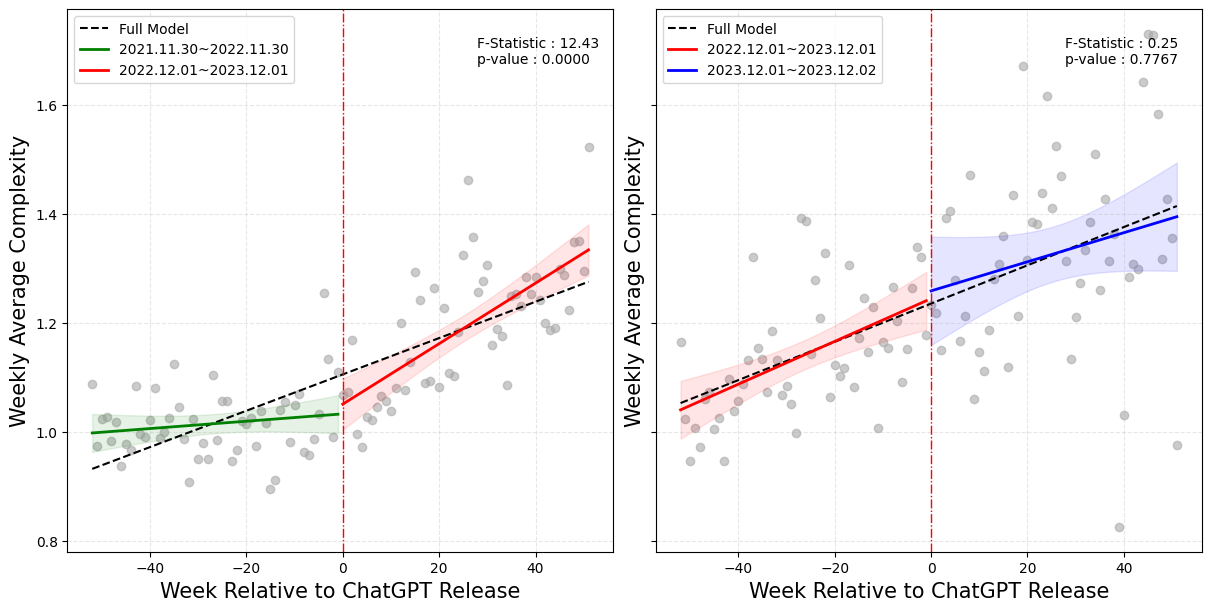

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True, constrained_layout=True)

plot_complexity(axs[0], chow_df_1year_2223, st_chow_1year_2223, F_stat_1_2223, p_value_1_2223, label_2223, color_2223)
plot_complexity(axs[1], chow_df_1year_2324, st_chow_1year_2324, F_stat_1_2324, p_value_1_2324, label_2324, color_2324)

# fig.tight_layout()
fig.savefig("./fig/Result_Fig3_1.png", dpi=300, bbox_inches='tight')  # DPI 설정 및 여백 최소화
plt.show();